# 03 - Model training and deployment using SageMaker

This notebook will cover the data modeling and deployment using AWS resources

## Table of Contents
* [1. Package & Data Import](#chapter1)
* [2. Upload Data to S3](#chapter2)
    * [2.1 Prepare Data](#chapter2.1)
    * [2.2 Uploading training data](#chapter2.2)
* [3. Model Training and Deployment](#chapter3)
    * [3.1. Train base model](#chapter3.2)
    * [3.2. Deploy and evaluate base model](#chapter3.2)
    * [3.3 Main model - LSTM Neural Network](#chapter3.3)
* [4. Train/Test Split](#chapter4)
* [5. Feature Engineering](#chapter5)
* [6. Save data for Modeling](#chapter6)

### 1. Package & Data Import <a class="anchor" id="chapter1"></a>
***

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3

import os

In [2]:
!pip install sagemaker==1.72.0

# Sagemaker
import sagemaker

     |████████████████████████████████| 297 kB 5.2 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=63ff97b327da946483e766bdfcbb3f1400fdeb76645ad5db82212f30077484d3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.38.0
    Uninstalling sagemaker-2.38.0:
      Successfully uninstalled sagemaker-2.38.0


In [3]:
X_train = pd.read_csv('../data/xtrain.csv', header = None)
X_test =  pd.read_csv('../data/xtest.csv', header = None)

y_train = pd.read_csv('../data/ytrain.csv', header = None)
y_test =  pd.read_csv('../data/ytest.csv', header = None)

In [4]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,183,44,1171,23,763,44,1415,454,1,23,...,0,0,0,0,0,0,0,0,0,0
1,131,166,166,13,166,166,22,433,414,5,...,0,0,0,0,0,0,0,0,0,0
2,101,21,42,33,16,12,120,1422,1578,401,...,0,0,0,0,0,0,0,0,0,0
3,161,1569,600,1,663,1562,142,320,172,28,...,0,0,0,0,0,0,0,0,0,0
4,64,11,238,44,330,633,1680,978,61,1,...,0,0,0,0,0,0,0,0,0,0


### 2. Upload data to S3
***

In [5]:
assert len(y_train) == len(X_train)
#len(X_train)

In [6]:
data_dir = '../data/'

#### 2.1 Prepare Data


In [7]:
aws_data = pd.concat([y_train, X_train], axis=1)

aws_data.to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [8]:
aws_data.head()

,0,0,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
0,0,52,7,93,819,3326,269,201,1856,180,...,0,0,0,0,0,0,0,0,0,0
1,0,69,1368,122,1275,2,2577,758,186,391,...,0,0,0,0,0,0,0,0,0,0
2,0,60,994,894,637,849,2152,69,51,40,...,0,0,0,0,0,0,0,0,0,0
3,0,134,7,11,51,99,3330,48,26,4,...,0,0,0,0,0,0,0,0,0,0
4,1,88,1512,1049,316,27,4,178,308,688,...,0,0,0,0,0,0,0,0,0,0


#### 2.2. Uploading training data

In [9]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [10]:
data_dir = "../data"
prefix = 'positiveness-lyrics'

# upload all data to S3
data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(data)

s3://sagemaker-us-east-2-890904620905/positiveness-lyrics


In [11]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

positiveness-lyrics/train.csv
positiveness-lyrics/word_dict.pkl
positiveness-lyrics/xtest.csv
positiveness-lyrics/xtrain.csv
positiveness-lyrics/ytest.csv
positiveness-lyrics/ytrain.csv
Test passed!


### 3. Model Training
***

#### 3.1 Train Base Model - naiveBayes

In [52]:
# your import and estimator code, here
from sagemaker.sklearn.estimator import SKLearn

output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate our custom SKLearn estimator
estimator = SKLearn(entry_point='train.py',
                    source_dir='./utilis/bayes_model',
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    py_version='py3',
                    framework_version='0.23-1',
                    sagemaker_session=sagemaker_session
                   
                   )

In [53]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': data})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-04 18:50:37 Starting - Starting the training job...
2021-05-04 18:50:39 Starting - Launching requested ML instances......
2021-05-04 18:51:42 Starting - Preparing the instances for training.........
2021-05-04 18:53:33 Downloading - Downloading input data
2021-05-04 18:53:33 Training - Downloading the training image...
2021-05-04 18:54:02 Uploading - Uploading generated training model
2021-05-04 18:54:02 Completed - Training job completed
2021-05-04 18:53:50,393 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-04 18:53:50,396 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-04 18:53:50,405 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-04 18:53:50,784 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-04 18:53:52,210 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-04 18:53:

#### 3.2. Deploy and evaluate base model

In [54]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!

In [50]:
type(X_test)

pandas.core.frame.DataFrame

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# generate predictions

y_preds  = predictor.predict(X_test)
#print(y_preds)
accuracy = accuracy_score(y_test, [round(num) for num in y_preds[:,1]])
auc = roc_auc_score(y_test, y_preds[:,1])

print(f"The estimator had an auc of {auc:.2%} and an accruacy of {accuracy:.2%} in the test set")

The estimator had an auc of 55.32% and an accruacy of 51.00% in the test set


In [66]:
pd.DataFrame(y_preds).to_csv("../predictions/bayes_predictions.csv", index=False)

In [71]:
#clean endpoint
boto3.client('sagemaker').delete_endpoint(EndpointName=estimator.endpoint)

AttributeError: 'SKLearn' object has no attribute 'endpoint'

#### 3.3 Main model - LSTM Neural Network

##### 3.3.1 Testing the model before deployment

In [12]:
import torch
import torch.utils.data

train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [29]:
train_sample

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,0,52,7,93,819,1,269,201,1,180,...,0,0,0,0,0,0,0,0,0,0
1,0,69,1,122,1,2,1,758,186,391,...,0,0,0,0,0,0,0,0,0,0
2,0,60,994,894,637,849,1,69,51,40,...,0,0,0,0,0,0,0,0,0,0
3,0,134,7,11,51,99,1,48,26,4,...,0,0,0,0,0,0,0,0,0,0
4,1,88,1,1,316,27,4,178,308,688,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,144,1,1,794,885,813,1,1,57,...,0,0,0,0,0,0,0,0,0,0
796,1,254,10,53,53,53,343,12,53,53,...,0,0,0,0,0,0,0,0,0,0
797,1,56,676,326,78,1,35,207,61,814,...,0,0,0,0,0,0,0,0,0,0
798,1,271,1,1,1,181,4,217,341,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # clear gradiants
            optimizer.zero_grad()
            
            # compute the model output
            out = model(batch_X)
            
            # calculate loss
            loss = loss_fn(out, batch_y)
            
            # backward propagation
            loss.backward()
            
            # update model weights with optimizer
            optimizer.step()
            
            total_loss += loss.data.item()
        print(f"Epoch: {epoch}, BCELoss: {total_loss / len(train_loader)}")

In [31]:
import torch.optim as optim
from utilis.lstm_model.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6898287311196327
Epoch: 2, BCELoss: 0.6772803962230682
Epoch: 3, BCELoss: 0.6649945974349976
Epoch: 4, BCELoss: 0.6455747671425343
Epoch: 5, BCELoss: 0.6209660843014717


##### 3.3.2. Train and deploy model

In [13]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="./utilis/lstm_model",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    hyperparameters={
                        'epochs': 20,
                        'hidden_dim': 200,
                        'vocab_size': 4000,
                        'seed': 123
                    })

In [14]:
estimator.fit({'training': data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-05-05 19:03:44 Starting - Starting the training job...
2021-05-05 19:03:46 Starting - Launching requested ML instances......
2021-05-05 19:05:10 Starting - Preparing the instances for training......
2021-05-05 19:06:08 Downloading - Downloading input data...
2021-05-05 19:06:33 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-05-05 19:06:49,034 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-05-05 19:06:49,037 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-05 19:06:49,048 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-05-05 19:06:52,079 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-05-05 19:06:52,447 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-05-05 19:06:52,4

In [14]:
project_predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

##### 3.3.3 Get predictions of LSTM model

In [15]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, project_predictor.predict(array))
    
    return predictions

In [16]:
predictions = predict(X_test.values)
predictions_label = [round(num) for num in predictions]

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y_test, predictions_label)
auc = roc_auc_score(y_test, predictions)

print(f"The estimator had an auc of {auc:.2%} and an accruacy of {accuracy:.2%} in the test set")

The estimator had an auc of 51.49% and an accruacy of 52.00% in the test set


In [18]:
pd.DataFrame(predictions).to_csv("../predictions/lstm_predictions.csv", index = False) # save for later

##### 3.3.4. Test Deployment on Individual Lyric

In [24]:
import pickle
with open("../data/word_dict.pkl", "rb") as f:
        word_dict = pickle.load(f)

In [19]:
test = "Imagine there's no heaven It's easy if you try No hell below us Above us only sky Imagine all the people Living for today"

In [20]:
#!pip install nltk

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('words')

def lyrics_to_words(lyrics):
    '''
    helper function to clean out song lyrics. We apply porter Stemmer algorithm and remove stopwords
    '''
    stopwords = nltk.corpus.stopwords.words('english')
    newStopWords = ['verse','1', '2', 'chorus', 'bridge', 'talking', 'refrain', 'explain', 'request']
    stopwords.extend(newStopWords)
    stemmer = PorterStemmer()
    
    words_english = set(nltk.corpus.words.words())

    remove_non_english = " ".join(w for w in nltk.wordpunct_tokenize(lyrics) if w.lower() in words_english or not w.isalpha())
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", remove_non_english.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [22]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

In [25]:
process_data = lyrics_to_words(test)

data_processed, length = convert_and_pad(word_dict, process_data)

test_data = np.append(length, np.array(data_processed)).reshape(1,-1) # add the length in the beggining

In [30]:
test_data

array([[  12, 1056,  196,  291,   49,  270,   51,   51,  242, 1056,  156,
          63,  297,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [52]:
project_predictor.predict(test_data)

array(0.6079634, dtype=float32)

In [59]:
project_predictor.delete_endpoint()

### 4. Model Evaluation
In this section I quickly compare both models with some visualizations and metrics
***

In [65]:
y_preds_bayes = pd.read_csv("../predictions/bayes_predictions.csv").iloc[:,1]
y_preds_lstm = pd.read_csv("../predictions/lstm_predictions.csv").iloc[:,0]

print(y_preds_bayes[:5])
print(y_preds_lstm[:5])

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 1, dtype: float64
0    0.342572
1    0.775257
2    0.422606
3    0.223613
4    0.205858
Name: 0, dtype: float64


In [66]:
y_preds_bayes.describe()

count    200.000000
mean       0.055000
std        0.228552
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: 1, dtype: float64

In [67]:
models = {
    'predictions': [y_preds_bayes, y_preds_lstm],
    'labels': ['Naive Bayes', 'LSTM'],
    'colors': ['#FF8F33', '#C70039']
}

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

def print_classification_reports(models, X_test, y_test):
    
    '''
    function that prints out the confusion matrixes for the the test set of a list of models
    -----------------------------------------------------------------------
    arguments:
        models (dictionary) = dictionary with model objects and labels. Example: {'models':[model1], 'labels':[label1]}
        X_test (pandas DataFrame) = dataframe used for testing the model
        y_test (numpy array or Pandas Data Frame) = array with actual values of your target variable in the testing set
    '''
    
    for pred, label in zip(models['predictions'], models['labels']):
        
        pred = [round(num) for num in pred]
        report = classification_report(y_test, pred)
        matrix = confusion_matrix(y_test, pred)
        
        matrix_df = pd.DataFrame(matrix)
        matrix_df.columns = ['Predicted 0', 'Predicted 1']
        matrix_df.index = ['Actual 0', 'Actual 1']
        
        print(f"Model analyzed: {label} \n")
        print(matrix_df)
        print(report)
        print("==============================")

In [69]:
print_classification_reports(models, X_test, y_test)

Model analyzed: Naive Bayes 

          Predicted 0  Predicted 1
Actual 0           95            4
Actual 1           94            7
              precision    recall  f1-score   support

           0       0.50      0.96      0.66        99
           1       0.64      0.07      0.13       101

    accuracy                           0.51       200
   macro avg       0.57      0.51      0.39       200
weighted avg       0.57      0.51      0.39       200

Model analyzed: LSTM 

          Predicted 0  Predicted 1
Actual 0           54           45
Actual 1           51           50
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        99
           1       0.53      0.50      0.51       101

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200



In [70]:
def plot_roc_curves(models, X_test, y_test):
    '''
    function that prints out the roc-auc score for the training set and the test set of a given model
    -----------------------------------------------------------------------
    arguments:
        models (dictionary) = dictionary with model objects and labels. Example: {'classifiers':[model1], 'labels':[label1]}
        X_test (pandas DataFrame) = dataframe used for testing the model
        y_test (numpy array or Pandas Data Frame) = array with actual values of your target variable in the testing set
    '''
    from sklearn.metrics import roc_auc_score, roc_curve
    
    result_table = pd.DataFrame(columns=['labels', 'fpr','tpr','auc'])
    
    for preds, label, color in zip(models['predictions'], models['labels'], models['colors']):
        
        y_preds  = preds
        
        # extract false positive rates and true positive rates
        fpr, tpr, thresholds = roc_curve(y_test, y_preds)
        auc = roc_auc_score(y_test, y_preds)
        
        result_table = result_table.append({'labels':label,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc,
                                            'color': color}, ignore_index=True)
        
   
    result_table.set_index('labels', inplace=True)
    
    # create figure and axe
    fig, ax = plt.subplots(figsize= (10,10))
    
    for i in result_table.index:

        ax1 = plt.plot(result_table.loc[i]['fpr'], 
                       result_table.loc[i]['tpr'], 
                       label=f"{i}: auc= {result_table.loc[i]['auc']:.2%}",
                       color = result_table.loc[i]['color'])
        
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    leg = ax.legend()
    
    return ax1

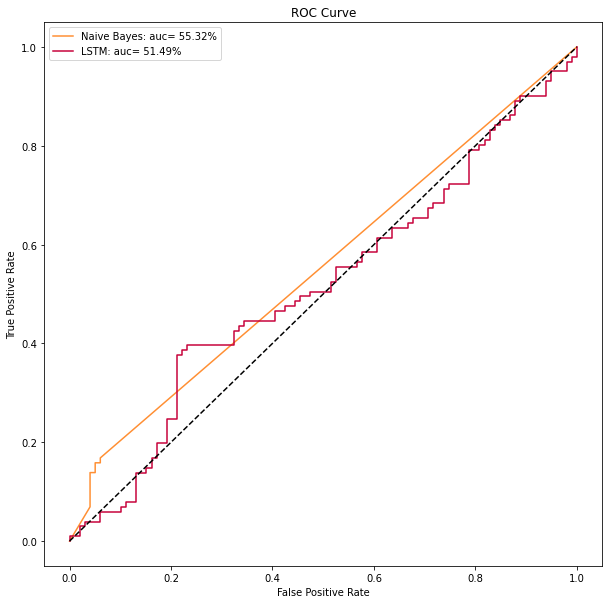

In [71]:
plot_roc_curves(models, X_test, y_test)

In [79]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(models, X_test, y_test, n_bins = 20):
    
    '''
    function that returns plots of calibrated probabilities of a classification model. 
    -----------------------------------------------------------------------
    arguments:
        models (dictionary) = dictionary with model objects and labels. Example: {'models':[model1], 'labels':[label1]}
        X_test (pandas DataFrame) = dataframe used for testing the model
        y_test (numpy array or Pandas Data Frame) = array with actual values of your target variable in the testing set
        n_bins (integer) = number of bins used for the plots
    '''    
    result_table = pd.DataFrame(columns=['labels', 'fraction_pos','mean_pred'])
        
    for pred, label, color in zip(models['predictions'], models['labels'], models['colors']):
                        
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, pred, n_bins=n_bins)
        
        result_table = result_table.append({'labels': label,
                                            'preds': pred,
                                            'fraction_pos': fraction_of_positives, 
                                            'mean_pred': mean_predicted_value,
                                            'color': color
                                            }, ignore_index=True)
        
    # create figure and axe
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    
    ax1.plot([0, 1], [0, 1], linestyle='--', color = 'black', label = 'Perfectly Calibrated Plot')
    
    for i in result_table.index:
        
        plot1 = ax1.plot(result_table.loc[i]['mean_pred'], 
                         result_table.loc[i]['fraction_pos'],
                         label = result_table.loc[i]['labels'],
                         marker='.',
                         color = result_table.loc[i]['color'])
        
        plot2 = sns.displot(x = result_table.loc[i]['preds'], 
                            bins = n_bins, 
                            label = result_table.loc[i]['labels'],
                             color = result_table.loc[i]['color']#,
                             #ax = ax2
                            )
        
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left")
    ax1.set_title('Calibration plots')

    #ax2.set_xlabel("Mean predicted value")
    #ax2.set_ylabel("Count")
    #ax2.legend(loc="upper right", ncol=2)

    return plot1, plot2

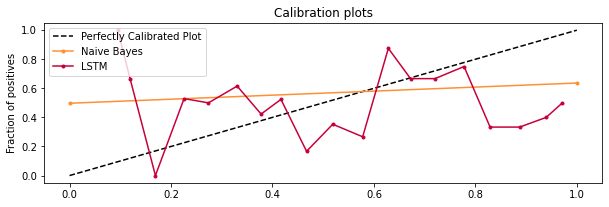

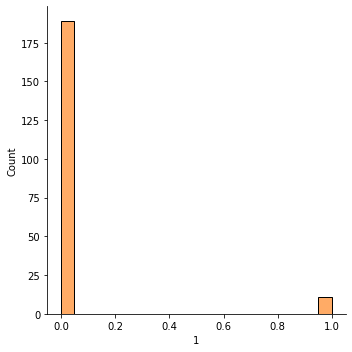

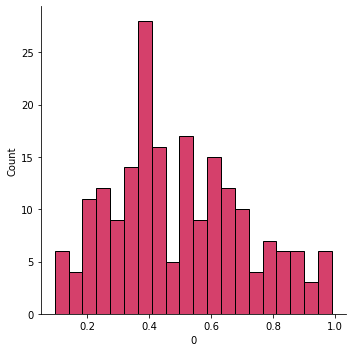

In [80]:
plot_calibration_curve(models, X_test, y_test, n_bins = 20)
plt.show()

### 4. Deploy the model for the web app

In [15]:
estimator

In [17]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='./utilis/lstm_model',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

In [27]:
test_data

array([[  12, 1056,  196,  291,   49,  270,   51,   51,  242, 1056,  156,
          63,  297,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [41]:
test = "Fuck you and all the other bitches here and there"

In [42]:
predictor.predict(test)

b'0'

In [43]:
predictor.endpoint

'sagemaker-pytorch-2021-05-05-20-22-04-657'

Lambda function used:
```python
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'sagemaker-pytorch-2021-05-05-20-22-04-657',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

URL generated while setting up the Public API:
https://pen9ve5p7g.execute-api.us-east-2.amazonaws.com/prod

In [35]:
print(word_dict)

{'love': 2, 'like': 3, 'know': 4, 'got': 5, 'oh': 6, 'time': 7, 'get': 8, 'let': 9, 'go': 10, 'come': 11, 'one': 12, 'yeah': 13, 'make': 14, 'babi': 15, 'never': 16, 'see': 17, 'way': 18, 'la': 19, 'take': 20, 'say': 21, 'need': 22, 'want': 23, 'away': 24, 'feel': 25, 'caus': 26, 'day': 27, 'night': 28, 'life': 29, 'back': 30, 'think': 31, 'heart': 32, 'girl': 33, 'de': 34, 'tell': 35, 'right': 36, 'could': 37, 'littl': 38, 'man': 39, 'keep': 40, 'said': 41, 'good': 42, 'give': 43, 'look': 44, 'still': 45, 'well': 46, 'world': 47, 'around': 48, 'tri': 49, 'find': 50, 'us': 51, 'fall': 52, 'hey': 53, 'everi': 54, 'would': 55, 'alway': 56, 'mi': 57, 'turn': 58, 'te': 59, 'wait': 60, 'mind': 61, 'ya': 62, 'live': 63, 'new': 64, 'hold': 65, 'insid': 66, 'long': 67, 'someon': 68, 'thing': 69, 'everyth': 70, 'walk': 71, 'yo': 72, 'home': 73, 'better': 74, 'head': 75, 'leav': 76, 'light': 77, 'hear': 78, 'call': 79, 'realli': 80, 'el': 81, 'boy': 82, 'ever': 83, 'gone': 84, 'show': 85, 'danc'

## Clean up Resources


In [17]:
project_predictor.endpoint

NameError: name 'project_predictor' is not defined

In [58]:
boto3.client('sagemaker').delete_endpoint(EndpointName=project_predictor.endpoint)


{'ResponseMetadata': {'RequestId': 'fbb6e7c9-6a14-44e4-99f2-74145bce0eac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fbb6e7c9-6a14-44e4-99f2-74145bce0eac',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 02 May 2021 18:15:37 GMT'},
  'RetryAttempts': 0}}

In [ ]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()